In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import math as m
from sklearn.metrics import accuracy_score
%matplotlib inline
sns.set()

In [2]:
data = pd.read_csv('diabetes.csv')

### Understanding data

0    500
1    268
Name: Outcome, dtype: int64

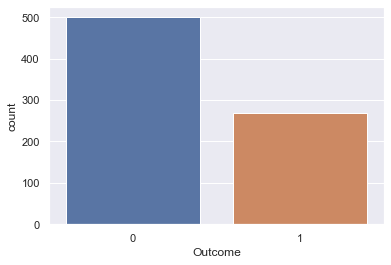

In [3]:
barplot = sns.countplot(x="Outcome", data=data)
data.Outcome.value_counts()

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


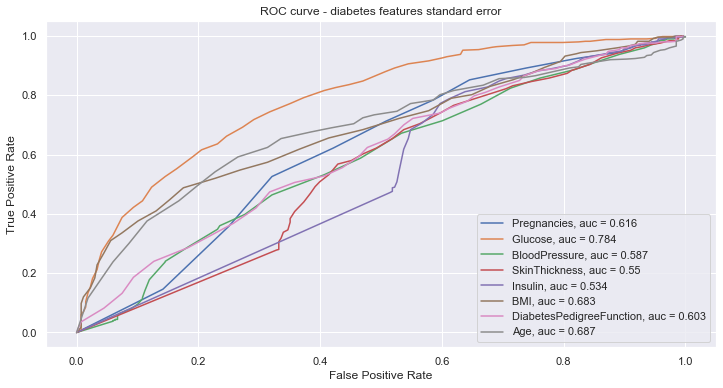

In [5]:
from sklearn.metrics import auc

X2, y2 = data.drop('Outcome', axis=1), data.Outcome
y2_ = y2 == 0

plt.figure(figsize=(12,6))
for col in range(X2.shape[1]):
    tpr,fpr = [],[]
    for threshold in np.linspace(min(X2.iloc[:,col]),max(X2.iloc[:,col]),100):
        detP = X2.iloc[:,col] < threshold
        tpr.append(sum(detP & y2_)/sum(y2_)) # TP/P
        fpr.append(sum(detP & (~y2_))/sum((~y2_))) # FP/N
        
    if auc(fpr,tpr) < .5:
        aux = tpr
        tpr = fpr
        fpr = aux
    plt.plot(fpr,tpr,label= data.columns[col] + ', auc = '+ str(np.round(auc(fpr,tpr),decimals=3)))

plt.title('ROC curve - diabetes features standard error')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

<Figure size 432x288 with 0 Axes>

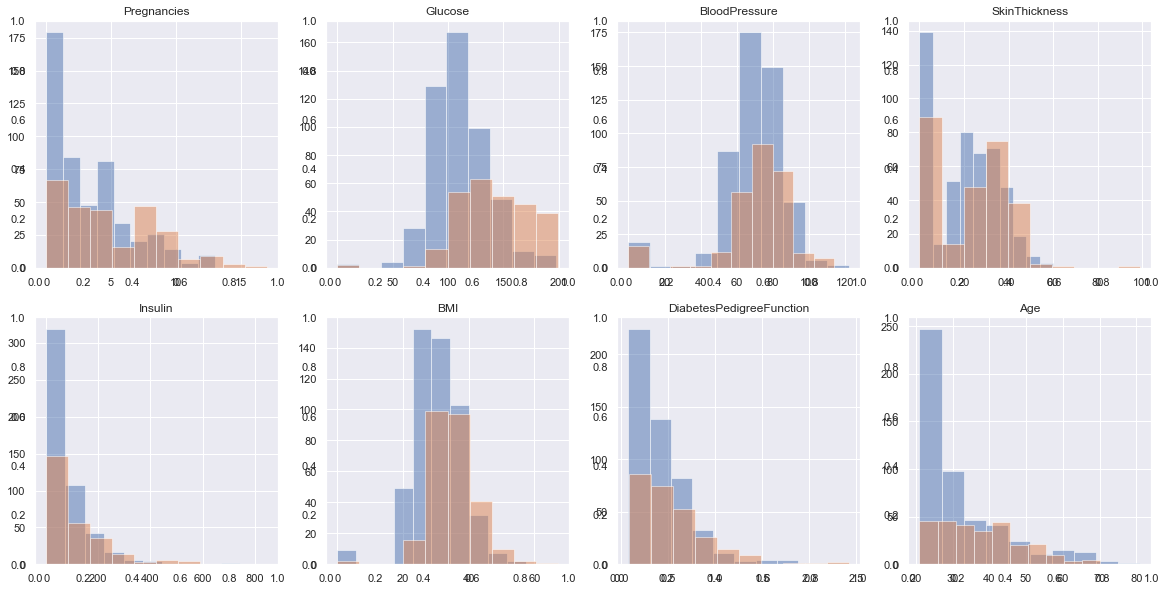

In [6]:
data = pd.read_csv('diabetes.csv')

target_0 = data.loc[data['Outcome']==0]
target_1 = data.loc[data['Outcome']==1]

def plot_hist(Feature_list):
    fig = plt.figure()
    rows = 2
    cols = 4
    i = 1
    fig, ax = plt.subplots(rows, cols, figsize=(20,10))
    for feature in Feature_list:
        fig.add_subplot(rows, cols, i)
        plt.hist(target_0[feature], alpha=0.5)
        plt.hist(target_1[feature], alpha=0.5)
        plt.title(feature)
        i = i+1   
    return 

Feature_list=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness','Insulin', 'BMI',
             'DiabetesPedigreeFunction', 'Age']
plot_hist(Feature_list)

### Data preprocessing

In [7]:
data = data.sample(frac=1, random_state=1).reset_index(drop=True)

In [8]:
X = data.drop('Outcome',axis=1)
y = data['Outcome']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
standardized = scaler.transform(X)
standardized = pd.DataFrame(standardized)


In [9]:
#Separate data into 4 sets, last set is test set
X_set_1 = standardized.iloc[:192].to_numpy()
y_set_1 = y.iloc[:192].to_numpy()

X_set_2 = standardized.iloc[192:384].to_numpy()
y_set_2 = y.iloc[192:384].to_numpy()

X_set_3 = standardized.iloc[384:576].to_numpy()
y_set_3 = y.iloc[384:576].to_numpy()

X_set_test = standardized.iloc[576:].to_numpy()
y_set_test = y.iloc[576:].to_numpy()

In [10]:
#Create 3 sets of train data and validation data set
X_train_1 = np.vstack((X_set_1, X_set_2))
y_train_1 = np.concatenate((y_set_1, y_set_2))
X_val_1 = X_set_3
y_val_1 = y_set_3
print(X_train_1.shape, y_train_1.shape, X_val_1.shape, y_val_1.shape)

X_train_2 = np.vstack((X_set_1, X_set_3))
y_train_2 = np.concatenate((y_set_1, y_set_3))
X_val_2 = X_set_2
y_val_2 = y_set_2
print(X_train_2.shape, y_train_2.shape, X_val_2.shape, y_val_2.shape)

X_train_3 = np.vstack((X_set_2, X_set_3))
y_train_3 = np.concatenate((y_set_2, y_set_3))
X_val_3 = X_set_1
y_val_3 = y_set_1
print(X_train_3.shape, y_train_3.shape, X_val_3.shape, y_val_3.shape)

(384, 8) (384,) (192, 8) (192,)
(384, 8) (384,) (192, 8) (192,)
(384, 8) (384,) (192, 8) (192,)


### Perceptron Model

In [11]:
def predict(w, row, b):
    z = np.dot(w, row)+b
    return 1 if z>= 0 else 0

def fit1(X_train, y_train, X_val, y_val, lr, n_epochs):
    
    n_features = X_train.shape[1]
    n_rows = X_train.shape[0]
    w = np.zeros(n_features)
    b = 0.0

    for n in range(n_epochs):
        train_sum_error =0
        predict_train_list = []
        for row in range(n_rows):
            train_prediction = predict(w, X_train[row], b)
            train_error = y_train[row]-train_prediction
            train_sum_error += train_error**2
            b += lr*train_error
            w += lr*train_error*X_train[row]
            predict_train_list.append(train_prediction)
        train_mean_error = round(train_sum_error/n_rows, 4)
        train_score = accuracy_score(y_train, predict_train_list)
        
        if n%1 ==0: #after training one epoch, validate with val_set
            val_sum_error = 0 
            predict_val_list = []
            for row in range(X_val.shape[0]):
                val_prediction = predict(w, X_val[row], b)
                val_error = (y_val[row]-val_prediction)**2
                predict_val_list.append(val_prediction)
                val_sum_error += val_error
            val_mean_error = round(val_sum_error/X_val.shape[0], 4)
            score = accuracy_score(y_val, predict_val_list)
            print('epoch',n,'train_mean_error', train_mean_error,'val_mean_error', val_mean_error, 'train_score', train_score, 'val_score', score)        
    return w, b

w1,b1 = fit1(X_train_1, y_train_1, X_val_1, y_val_1, lr=0.01, n_epochs=5)
print(w1, b1)
print()
w2,b2 = fit1(X_train_2, y_train_2, X_val_2, y_val_2, lr=0.01, n_epochs=5)
print(w2, b2)
print()
w3,b3 = fit1(X_train_3, y_train_3, X_val_3, y_val_3, lr=0.01, n_epochs=5)
print(w3, b3)
    

epoch 0 train_mean_error 0.3516 val_mean_error 0.2656 train_score 0.6484375 val_score 0.734375
epoch 1 train_mean_error 0.3281 val_mean_error 0.3438 train_score 0.671875 val_score 0.65625
epoch 2 train_mean_error 0.2891 val_mean_error 0.2656 train_score 0.7109375 val_score 0.734375
epoch 3 train_mean_error 0.3281 val_mean_error 0.2812 train_score 0.671875 val_score 0.71875
epoch 4 train_mean_error 0.2891 val_mean_error 0.2448 train_score 0.7109375 val_score 0.7552083333333334
[-0.02216808  0.06625092 -0.02982112 -0.00212687 -0.01594193  0.02269029
 -0.00275952  0.0116763 ] -0.03

epoch 0 train_mean_error 0.3255 val_mean_error 0.3021 train_score 0.6744791666666666 val_score 0.6979166666666666
epoch 1 train_mean_error 0.2708 val_mean_error 0.2812 train_score 0.7291666666666666 val_score 0.71875
epoch 2 train_mean_error 0.3151 val_mean_error 0.3281 train_score 0.6848958333333334 val_score 0.671875
epoch 3 train_mean_error 0.3073 val_mean_error 0.2865 train_score 0.6927083333333334 val_sco

In [12]:
y_test_1 = ((X_set_test@w1)+b1)
y_test_2 = ((X_set_test@w2)+b2)
y_test_3 = ((X_set_test@w3)+b3)

y_test_1= np.heaviside(y_test_1, 0)
y_test_2= np.heaviside(y_test_2, 0)
y_test_3= np.heaviside(y_test_3, 0)


test_score1 = accuracy_score(y_set_test, y_test_1)
test_score2 = accuracy_score(y_set_test, y_test_2)
test_score3 = accuracy_score(y_set_test, y_test_3)

print(round(test_score1,4), round(test_score2,4), round(test_score3,4))

0.7031 0.7188 0.7031


### Compare with other models

In [13]:
data = pd.read_csv('diabetes.csv')
from sklearn.model_selection import train_test_split
X1 = data[['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']]
y1 = data['Outcome']
X_train0, X_test0, y_train0, y_test0 = train_test_split(X1,y1, test_size=0.25, random_state=20)

#### Logistic Regression Model

In [14]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(max_iter=500, solver = 'lbfgs', penalty='none', dual=False, tol=0.01, 
                           C=1, fit_intercept=True, intercept_scaling=1.0, 
                           class_weight=None, random_state=None)
lr.fit(X_train0,y_train0)
pred_train_lr = lr.predict(X_train0)
pred_test_1r =lr.predict(X_test0)

score_train_1g = accuracy_score(y_train0, pred_train_lr)
score_test_1g = accuracy_score(y_test0, pred_test_1r)
print('score_train', round(score_train_1g,4))
print('score_test', round(score_test_1g,4))

score_train 0.7847
score_test 0.7656


#### Support Vector Classifier

In [15]:
from sklearn import svm
from sklearn.svm import SVC

In [16]:
svm_clf = SVC(kernel='linear', gamma=0.002, C=1)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Construct pipelines
pipe = Pipeline([('scale', StandardScaler()),
                ('svm', SVC(kernel='linear', gamma = 0.002, C=1))])

param_grid = dict(svm__gamma = np.arange(0.001, 0.3, 0.01),
                  svm__C = np.arange(0.1,0.4,0.01))
             
from sklearn.model_selection import GridSearchCV

svm_grid = GridSearchCV(pipe, param_grid=param_grid, cv=3, scoring= 'accuracy', n_jobs=4)
svm_grid.fit(X_train0, y_train0)
print(svm_grid.best_params_)

{'svm__C': 0.20999999999999996, 'svm__gamma': 0.001}


In [17]:
y_pred_svm_train = svm_grid.best_estimator_.predict(X_train0)
y_pred_svm_test = svm_grid.best_estimator_.predict(X_test0)

print('accuracy_score train set', round(accuracy_score(y_train0, y_pred_svm_train),4))
print('accuracy_score test set', round(accuracy_score(y_test0, y_pred_svm_test),4))

accuracy_score train set 0.7847
accuracy_score test set 0.7656


### 6 Outlier Data Removal

In [18]:
data2 = data.sample(frac=1, random_state=2).reset_index(drop=True)
data2 = data2[(data2[['Pregnancies','Glucose', 'BloodPressure', 'SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']] != 0).all(axis=1)]
data2

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,88,74,19,53,29.0,0.229,22,0
4,1,144,82,46,180,46.1,0.335,46,1
5,2,98,60,17,120,34.7,0.198,22,0
6,1,88,62,24,44,29.9,0.422,23,0
9,3,163,70,18,105,31.6,0.268,28,1
...,...,...,...,...,...,...,...,...,...
759,5,189,64,33,325,31.2,0.583,29,1
763,1,77,56,30,56,33.3,1.251,24,0
764,8,124,76,24,600,28.7,0.687,52,1
765,4,125,70,18,122,28.9,1.144,45,1


In [19]:
X = data2.drop('Outcome',axis=1)
y = data2['Outcome']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
standardized = scaler.transform(X)
standardized = pd.DataFrame(standardized)

In [20]:
#Separate data into 4 sets, last set is test set
X_set_1 = standardized.iloc[:84].to_numpy()
y_set_1 = y.iloc[:84].to_numpy()

X_set_2 = standardized.iloc[84:168].to_numpy()
y_set_2 = y.iloc[84:168].to_numpy()

X_set_3 = standardized.iloc[168:252].to_numpy()
y_set_3 = y.iloc[168:252].to_numpy()

X_set_test = standardized.iloc[252:].to_numpy()
y_set_test = y.iloc[252:].to_numpy()

In [21]:
#Create 3 sets of train data and validation data set
X_train_1 = np.vstack((X_set_1, X_set_2))
y_train_1 = np.concatenate((y_set_1, y_set_2))
X_val_1 = X_set_3
y_val_1 = y_set_3
print(X_train_1.shape, y_train_1.shape, X_val_1.shape, y_val_1.shape)

X_train_2 = np.vstack((X_set_1, X_set_3))
y_train_2 = np.concatenate((y_set_1, y_set_3))
X_val_2 = X_set_2
y_val_2 = y_set_2
print(X_train_2.shape, y_train_2.shape, X_val_2.shape, y_val_2.shape)

X_train_3 = np.vstack((X_set_2, X_set_3))
y_train_3 = np.concatenate((y_set_2, y_set_3))
X_val_3 = X_set_1
y_val_3 = y_set_1
print(X_train_3.shape, y_train_3.shape, X_val_3.shape, y_val_3.shape)

(168, 8) (168,) (84, 8) (84,)
(168, 8) (168,) (84, 8) (84,)
(168, 8) (168,) (84, 8) (84,)


In [44]:
w1,b1 = fit1(X_train_1, y_train_1, X_val_1, y_val_1, lr=0.01, n_epochs=2)
print(w1, b1)
print()
w2,b2 = fit1(X_train_2, y_train_2, X_val_2, y_val_2, lr=0.01, n_epochs=2)
print(w2, b2)
print()
w3,b3 = fit1(X_train_3, y_train_3, X_val_3, y_val_3, lr=0.01, n_epochs=2)
print(w3, b3)

epoch 0 train_mean_error 0.3274 val_mean_error 0.2619 train_score 0.6726190476190477 val_score 0.7380952380952381
epoch 1 train_mean_error 0.2976 val_mean_error 0.2381 train_score 0.7023809523809523 val_score 0.7619047619047619
[ 0.02402793  0.02890135 -0.01560784  0.00487667  0.01450625  0.01335409
  0.02787603 -0.00142784] -0.03

epoch 0 train_mean_error 0.3452 val_mean_error 0.2857 train_score 0.6547619047619048 val_score 0.7142857142857143
epoch 1 train_mean_error 0.3214 val_mean_error 0.2619 train_score 0.6785714285714286 val_score 0.7380952380952381
[ 0.03309757  0.00394259 -0.02189051  0.05535611 -0.00502588 -0.00599256
  0.01124108  0.05778606] -0.04

epoch 0 train_mean_error 0.3333 val_mean_error 0.3214 train_score 0.6666666666666666 val_score 0.6785714285714286
epoch 1 train_mean_error 0.3095 val_mean_error 0.3095 train_score 0.6904761904761905 val_score 0.6904761904761905
[ 0.03215085  0.02136666 -0.01825495  0.03418028 -0.00319651  0.0103536
  0.00162635  0.05076942] -0.060

In [50]:
y_test_1 = ((X_set_test@w1)+b1)
y_test_2 = ((X_set_test@w2)+b2)
y_test_3 = ((X_set_test@w3)+b3)

y_test_1= np.heaviside(y_test_1, 0)
y_test_2= np.heaviside(y_test_2, 0)
y_test_3= np.heaviside(y_test_3, 0)


test_score1 = accuracy_score(y_set_test, y_test_1)
test_score2 = accuracy_score(y_set_test, y_test_2)
test_score3 = accuracy_score(y_set_test, y_test_3)

print(round(test_score1,4), round(test_score2,4), round(test_score3,5))

0.869 0.7143 0.70238


#### Testing with Logistic Regression

In [46]:
Xm1 = data2[['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']]
ym1 = data2['Outcome']
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(Xm1,ym1, test_size=0.25, random_state=27)

#### Testing with Logistic Regression

In [47]:
lr=LogisticRegression(max_iter=500, solver = 'lbfgs', penalty='none', dual=False, tol=0.01, 
                           C=1, fit_intercept=True, intercept_scaling=1.0, 
                           class_weight=None, random_state=None)
lr.fit(X_train_m,y_train_m)
pred_train_lr = lr.predict(X_train_m)
pred_test_1r =lr.predict(X_test_m)

score_train_1g = accuracy_score(y_train_m, pred_train_lr)
score_test_1g = accuracy_score(y_test_m, pred_test_1r)
print('score_train', score_train_1g)
print('score_test', score_test_1g)

score_train 0.7817460317460317
score_test 0.8452380952380952


#### Testing with SVM

In [48]:
svm_clf = SVC(kernel='linear', gamma=0.002, C=1)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Construct pipelines
pipe = Pipeline([('scale', StandardScaler()),
                ('svm', SVC(kernel='linear', gamma = 0.002, C=1))])

param_grid = dict(svm__gamma = np.arange(0.0001, 0.1, 0.01),
                  svm__C = np.arange(0.01,0.5,0.01))
             
from sklearn.model_selection import GridSearchCV

svm_grid = GridSearchCV(pipe, param_grid=param_grid, cv=3, scoring= 'accuracy', n_jobs=4)
svm_grid.fit(X_train_m,y_train_m)
print(svm_grid.best_params_)

{'svm__C': 0.02, 'svm__gamma': 0.0001}


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [49]:
y_pred_svm_train_m = svm_grid.best_estimator_.predict(X_train_m)
y_pred_svm_test_m = svm_grid.best_estimator_.predict(X_test_m)

print('accuracy_score train set', accuracy_score(y_train_m, y_pred_svm_train_m))
print('accuracy_score test set', accuracy_score(y_test_m, y_pred_svm_test_m))

accuracy_score train set 0.7817460317460317
accuracy_score test set 0.8690476190476191
